# Clase 2 - Ingeniería de características

## Descripción de los datos a utilizar

En esta clase usaremos el dataset del Titanic proporcionado por Kaggle <https://www.kaggle.com/competitions/titanic/data>

**Descripción general**

**Los datos se han dividido en dos grupos:**

* conjunto de entrenamiento (train.csv)
* conjunto de prueba (test.csv)

El conjunto de entrenamiento se debe utilizar para crear sus modelos de aprendizaje automático. Para el conjunto de entrenamiento, proporcionamos el resultado (también conocido como la "verdad fundamental") para cada pasajero. Su modelo se basará en "características" como el género y la clase de los pasajeros. También puede utilizar la ingeniería de características para crear nuevas características.

El conjunto de prueba se debe utilizar para ver qué tan bien se desempeña su modelo con datos no vistos. Para el conjunto de prueba, no proporcionamos la verdad fundamental para cada pasajero. Es su trabajo predecir estos resultados. Para cada pasajero en el conjunto de prueba, use el modelo que entrenó para predecir si sobrevivió o no al hundimiento del Titanic.

También incluimos gender_submission.csv, un conjunto de predicciones que suponen que todos y solo los pasajeros femeninos sobreviven, como un ejemplo de cómo debería verse un archivo de envío.

Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them

## Configuración de librerías y carga de los datos

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import time
import os
import subprocess
import zipfile
from typing import List, Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [2]:
import os
import subprocess
import zipfile

# Define the folder and competition details
data_folder = "../data"
titanic_folder = os.path.join(data_folder, "titanic")
competition_name = "titanic"
zip_file_path = os.path.join(data_folder, f"{competition_name}.zip")

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"Folder '{data_folder}' created.")
else:
    print(f"Folder '{data_folder}' already exists.")

# Check if the Titanic folder already exists
if os.path.exists(titanic_folder):
    print(f"'{titanic_folder}' already exists. No need to download.")
else:
    # Download the dataset using the Kaggle API
    try:
        print("Downloading the dataset...")
        subprocess.run(
            ["kaggle", "competitions", "download", "-c", competition_name, "-p", data_folder],
            check=True
        )
        print(f"Dataset downloaded successfully to '{data_folder}'.")

        # Unzip the downloaded file
        print("Unzipping the dataset...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(titanic_folder)
        print(f"Dataset unzipped to '{titanic_folder}'.")

        # Delete the zip file
        os.remove(zip_file_path)
        print(f"Deleted zip file: {zip_file_path}")

    except FileNotFoundError:
        print("Error: Ensure the Kaggle API is installed and the 'kaggle' command is available.")
    except subprocess.CalledProcessError:
        print("Error: Unable to download the dataset. Check your Kaggle API setup and competition name.")
    except zipfile.BadZipFile:
        print("Error: The downloaded zip file is corrupted.")
# Define the file path
file_path = "../data/titanic"

Folder '../data' already exists.
'../data/titanic' already exists. No need to download.


In [3]:
train = pd.read_csv(file_path + "/train.csv")  # Asegúrate de tener el archivo descargado
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# Cargar dataset Titanic
test = pd.read_csv(file_path + "/test.csv")  # Asegúrate de tener el archivo descargado
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Limpieza de datos

### Validación de formato

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Generamos un diccionario con las variables

In [6]:
columns_to_process: List[str] = ['Pclass', 'Embarked', 'Sex','SibSp','Parch','Cabin']
unique_values_dict = utils.get_unique_values(train, columns_to_process)
utils.save_dict_as_json(unique_values_dict,file_path , "unique_values.json")

Dictionary saved to ../data/titanic/unique_values.json


#### Definimos categorías en la variable Clase

In [7]:
pclass_to_cat: Dict[int, str] = {1: "Upper", 2: "Middle", 3: "Lower"}
train = utils.map_column_values(train, 'Pclass', pclass_to_cat)
print(train['Pclass'].unique())
train.head()

['Lower' 'Upper' 'Middle']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,Lower,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,Upper,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,Lower,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,Upper,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,Lower,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Transformamos a categoría y string las que corresponden

In [8]:
categorical_columns = ['Pclass', 'Embarked', 'Cabin', 'Sex']
train = utils.transform_columns(train,categorical_columns , 'category')
train = utils.transform_columns(train, ['Name', 'Ticket'], 'str')
# Check the type of elements in the columns
print(type(train['Name'].iloc[0]))  # Should return <class 'str'>
print(type(train['Ticket'].iloc[0]))  # Should return <class 'str'>

<class 'str'>
<class 'str'>


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(4), float64(2), int64(4), object(2)
memory usage: 65.8+ KB


### Tratamiento de valores nulos

In [10]:
utils.null_values_table(train)

,Null Count,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


In [11]:
utils.null_values_table(test)

,Null Count,Percentage
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000


#### Edad

In [12]:
train.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8])

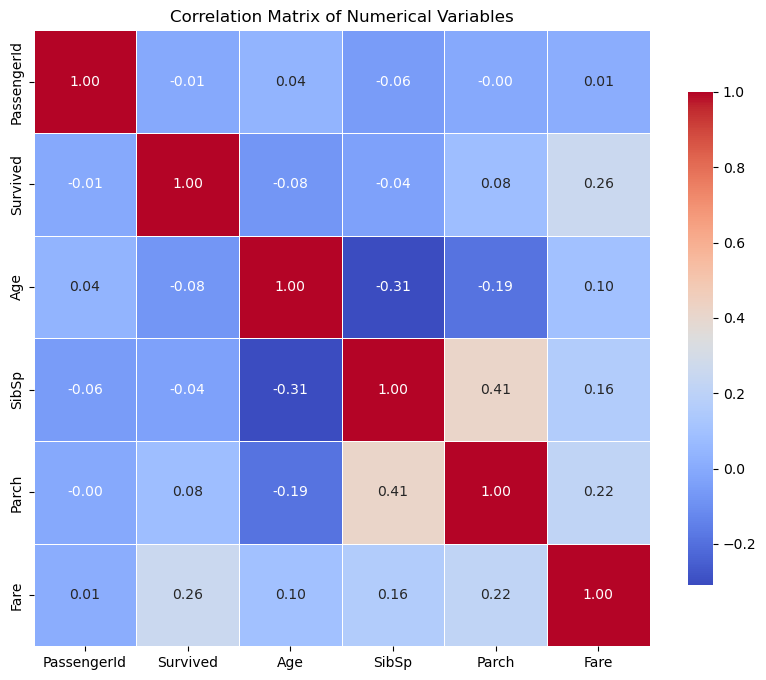

In [13]:
numerical_columns = train.select_dtypes(include=["float64", "int64"]).columns
correlation_matrix = train[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In [14]:
# Group by Sex and Cabin, and calculate statistics for Age
age_stats = train.groupby(['Pclass', 'Sex'])['Age'].describe().reset_index()
# Display the result
age_stats


/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/3982006869.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = train.groupby(['Pclass', 'Sex'])['Age'].describe().reset_index()


,Pclass,Sex,count,mean,std,min,25%,50%,75%,max
0,Lower,female,102.0,21.750000,12.729964,0.75,14.125,21.5,29.75,63.0
1,Lower,male,253.0,26.507589,12.159514,0.42,20.000,25.0,33.00,74.0
2,Middle,female,74.0,28.722973,12.872702,2.00,22.250,28.0,36.00,57.0
3,Middle,male,99.0,30.740707,14.793894,0.67,23.000,30.0,36.75,70.0
4,Upper,female,85.0,34.611765,13.612052,2.00,23.000,35.0,44.00,63.0
5,Upper,male,101.0,41.281386,15.139570,0.92,30.000,40.0,51.00,80.0


/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/1760316309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = LabelEncoder().fit_transform(X['Sex'])
/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/1760316309.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Pclass'] = LabelEncoder().fit_transform(X['Pclass'])


Root Mean Squared Error (RMSE): 12.139237685414606
Mean Absolute Error (MAE): 9.853363300536897
R-squared (R2): 0.2051901141879967


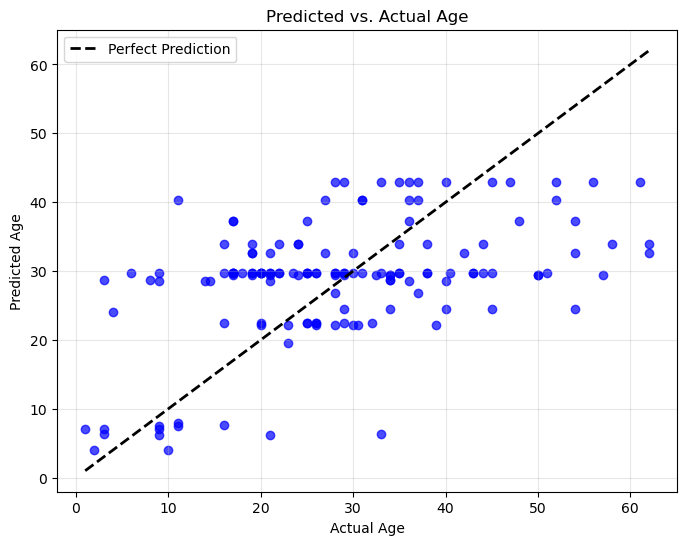

In [15]:
# Select relevant columns and drop rows where Age is missing
features = ['Pclass', 'Sex','SibSp']
target = 'Age'
# Prepare features and target
X = train[features]
y = train[target]

# Encode categorical variables
X['Sex'] = LabelEncoder().fit_transform(X['Sex'])
# Encode categorical variables
X['Pclass'] = LabelEncoder().fit_transform(X['Pclass'])

# Handle missing values in the target
X = X[y.notnull()]
y = y[y.notnull()]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values for the features (if any)
#imputer = SimpleImputer(strategy='most_frequent')
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)

# Train a XGBoost Regressor
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")
# Plot predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Prediction")
plt.title("Predicted vs. Actual Age")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
# Calculate the medians grouped by 'Pclass', 'Sex', and 'SibSp'
median_age_dict = (
    train.groupby(['Pclass', 'Sex', 'SibSp'])['Age']
    .median()
    .dropna()
    .to_dict()
)

# Convert tuple keys to strings
median_age_dict_str_keys = {str(key): value for key, value in median_age_dict.items()}

# Use utils.save_dict_as_json to save the dictionary
utils.save_dict_as_json(median_age_dict_str_keys, "../data/titanic", "median_age.json")


Dictionary saved to ../data/titanic/median_age.json


/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/634197204.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['Pclass', 'Sex', 'SibSp'])['Age']


In [17]:
# Fill NA values in Age using grouped medians
def fill_age_with_medians(row):
    key = (row['Pclass'], row['Sex'], row['SibSp'])
    if pd.isna(row['Age']) and key in median_age_dict:
        return median_age_dict[key]
    return row['Age']
# Apply the function to fill Age
train['Age'] = train.apply(fill_age_with_medians, axis=1)
# Handle remaining missing values with the overall median
train['Age'] = train['Age'].fillna(train['Age'].median())
# Verify the result
print(f"Remaining missing values in Age: {train['Age'].isnull().sum()}")

Remaining missing values in Age: 0


#### Cabin

In [18]:
# Add "M" to the categories of Cabin
train['Cabin'] = train['Cabin'].cat.add_categories("M")
# Fill missing values in Cabin with "M"
train['Cabin'] = train['Cabin'].fillna("M")
# Verify if there are any remaining missing values
print(f"Remaining missing values in Cabin: {train['Cabin'].isnull().sum()}")


Remaining missing values in Cabin: 0


#### Embarked

In [19]:
# Find rows where Embarked is null
null_embarked_rows = train[train['Embarked'].isnull()]
null_embarked_rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,Upper,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,Upper,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [20]:
# Check for matching rows in other columns
matching_rows = train[
    (train['Pclass'].isin(null_embarked_rows['Pclass'])) &
    (train['Sex'].isin(null_embarked_rows['Sex'])) &
    (train['SibSp'].isin(null_embarked_rows['SibSp'])) &
    (train['Parch'].isin(null_embarked_rows['Parch'])) 
    # (train['Fare'].isin(null_embarked_rows['Fare']))
    #(train['Cabin'].isin(null_embarked_rows['Cabin']))  
]
matching_rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
11,12,1,Upper,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
61,62,1,Upper,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
177,178,0,Upper,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
194,195,1,Upper,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44.0,0,0,PC 17610,27.7208,B4,C
195,196,1,Upper,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C
218,219,1,Upper,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C
256,257,1,Upper,"Thorne, Mrs. Gertrude Maybelle",female,31.5,0,0,PC 17585,79.2000,M,C
257,258,1,Upper,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S
258,259,1,Upper,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,M,C
269,270,1,Upper,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S


In [21]:
# Drop rows where Embarked is null
train = train.dropna(subset=['Embarked'])
# Verify if there are any remaining null values in Embarked
print(f"Remaining missing values in Embarked: {train['Embarked'].isnull().sum()}")


Remaining missing values in Embarked: 0


### Datos duplicados

In [22]:
# Check for duplicate rows in the DataFrame
duplicates = train[train.duplicated()]
# Print the number of duplicate rows
print(f"Number of duplicate rows: {len(duplicates)}")
# Display duplicate rows, if any
if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


### Datos anómalos, fuera de rango y/o corruptos

In [23]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,29.284218,0.524184,0.382452,32.096681
std,256.998173,0.486260,13.283213,1.103705,0.806761,49.697504
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,22.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,27.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [24]:
# Identify numerical columns
numerical_columns = ['Fare','Age','SibSp','Parch']

# Function to detect outliers using IQR
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# Detect outliers
outliers_dict = detect_outliers(train, numerical_columns)

# Display outliers
for col, outliers in outliers_dict.items():
    print(f"There is outliers in {col}:")


There is outliers in Fare:
There is outliers in Age:
There is outliers in SibSp:
There is outliers in Parch:


In [25]:
outliers_dict.get('Fare').groupby(['Pclass','Cabin'])['Fare'].describe().sort_values('count',ascending=False).head(10)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/1202296910.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outliers_dict.get('Fare').groupby(['Pclass','Cabin'])['Fare'].describe().sort_values('count',ascending=False).head(10)


count       mean         std       min        25%  \
Pclass Cabin                                                            
Upper  M             14.0  159.03065  112.943448   78.8500   88.23435   
Lower  M              7.0   69.55000    0.000000   69.5500   69.55000   
Middle M              5.0   73.50000    0.000000   73.5000   73.50000   
Upper  C23 C25 C27    4.0  263.00000    0.000000  263.0000  263.00000   
       B96 B98        4.0  120.00000    0.000000  120.0000  120.00000   
       C22 C26        3.0  151.55000    0.000000  151.5500  151.55000   
       D36            2.0  113.27500    0.000000  113.2750  113.27500   
       C78            2.0   90.00000    0.000000   90.0000   90.00000   
       C92            2.0   89.10420    0.000000   89.1042   89.10420   
       C93            2.0   90.00000    0.000000   90.0000   90.00000   

                         50%         75%       max  
Pclass Cabin                                        
Upper  M            133.6500  161.537525  512.3292  
Lower  M             69.5500   69.550000   69.5500  
Middle M             73.5000   73.500000   73.5000  
Upper  C23 C25 C27  263.0000  263.000000  263.0000  
       B96 B98      120.0000  120.000000  120.0000  
       C22 C26      151.5500  151.550000  151.5500  
       D36          113.2750  113.275000  113.2750  
       C78           90.0000   90.000000   90.0000  
       C92           89.1042   89.104200   89.1042  
       C93           90.0000   90.000000   90.0000

In [26]:
train[train.Cabin=='C23 C25 C27'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/2417349373.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[train.Cabin=='C23 C25 C27'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
Upper,4.0,263.0,0.0,263.0,263.0,263.0,263.0,263.0
Lower,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Middle,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train[train.Cabin=='B96 B98'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/1858690692.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[train.Cabin=='B96 B98'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
Upper,4.0,120.0,0.0,120.0,120.0,120.0,120.0,120.0
Lower,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Middle,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
train[train.Cabin=='C22 C26'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_11761/1573167292.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train[train.Cabin=='C22 C26'].groupby(['Pclass'])['Fare'].describe().sort_values('count',ascending=False)


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
Upper,3.0,151.55,0.0,151.55,151.55,151.55,151.55,151.55
Lower,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Middle,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploración

## Ingeniería de características

In [29]:
# Map Pclass (categorical) to ordinal values
pclass_to_ordinal = {"Upper": 3, "Middle": 2, "Lower": 1}
train['PclassOrdinal'] = train['Pclass'].map(pclass_to_ordinal)

In [30]:
# Encode categorical variables
encode_sex = LabelEncoder()
train['Sex'] = encode_sex.fit_transform(train['Sex'])  # male=1, female=0
encode_embarked = LabelEncoder()
train['Embarked'] = encode_embarked.fit_transform(train['Embarked'])  # S=0, C=1, Q=2
encode_cabin = LabelEncoder()
train['Cabin'] = encode_cabin.fit_transform(train['Cabin'])


In [31]:
# Create new feature: Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
# Create new feature: IsAlone
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
# Create new feature: Fare per person
train['FarePerPerson'] = train['Fare'] / train['FamilySize']

In [32]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PclassOrdinal,FamilySize,IsAlone,FarePerPerson
0,1,0,Lower,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,145,2,1,2,0,3.62500
1,2,1,Upper,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,80,0,3,2,0,35.64165
2,3,1,Lower,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,145,2,1,1,1,7.92500


## Selección de variables

In [33]:
categorical_columns = ['PclassOrdinal', 'Sex', 'IsAlone', 'Cabin','Embarked']
numerical_columns = ['Fare','Age','SibSp','Parch','FarePerPerson','FamilySize']
X = train.drop(columns=['Survived','Pclass', 'Name', 'Ticket','PassengerId'])
y = train['Survived']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Verify the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (666, 11)
X_test shape: (223, 11)
y_train shape: (666,)
y_test shape: (223,)


In [34]:
# Perform Chi-Square Test directly on encoded categorical features
chi_scores, p_values = chi2(X_train[categorical_columns], y_train)
# Create a DataFrame for results
chi2_results = pd.DataFrame({
    'Feature': categorical_columns,
    'Chi2 Score': chi_scores,
    'p-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

print(chi2_results)

         Feature  Chi2 Score       p-Value
3          Cabin  368.387536  4.200292e-82
1            Sex   66.224693  4.023405e-16
0  PclassOrdinal   29.787847  4.820041e-08
2        IsAlone    9.452484  2.108634e-03
4       Embarked    7.817555  5.174114e-03


In [35]:
# Compute ANOVA F-values and p-values
f_scores, p_values = f_classif(X_train[numerical_columns], y_train)
# Create a DataFrame with F-scores and p-values
anova_importance_df = pd.DataFrame({
    'Feature': numerical_columns,
    'F-Score': f_scores,
    'p-Value': p_values
}).sort_values(by='F-Score', ascending=False)

print(anova_importance_df)

         Feature    F-Score       p-Value
0           Fare  42.079551  1.712917e-10
4  FarePerPerson  31.621772  2.760849e-08
3          Parch   3.776174  5.240964e-02
2          SibSp   2.184249  1.399033e-01
1            Age   1.846003  1.747104e-01
5     FamilySize   0.002420  9.607829e-01


In [36]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

# Create a DataFrame for mutual information scores
mi_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

print(mi_scores_df)


          Feature  Mutual Information
0             Sex            0.172806
4            Fare            0.127936
10  FarePerPerson            0.115070
7   PclassOrdinal            0.065230
8      FamilySize            0.057644
6        Embarked            0.047854
5           Cabin            0.030943
9         IsAlone            0.024343
3           Parch            0.020692
1             Age            0.001199
2           SibSp            0.000000


In [37]:
# Compute Spearman's correlation for each feature
spearman_results = []
for col in numerical_columns:
    correlation, p_value = spearmanr(X_train[col], y_train)
    spearman_results.append((col, correlation, p_value))

# Create a DataFrame for Spearman's correlation results
spearman_df = pd.DataFrame(spearman_results, columns=['Feature', 'Spearman Correlation', 'p-Value'])
print(spearman_df.sort_values(by='Spearman Correlation', ascending=False))


         Feature  Spearman Correlation       p-Value
0           Fare              0.314343  9.690605e-17
4  FarePerPerson              0.269409  1.541360e-12
5     FamilySize              0.149482  1.078561e-04
3          Parch              0.137555  3.706414e-04
2          SibSp              0.072330  6.210257e-02
1            Age             -0.029923  4.407458e-01


In [38]:
# Train a Random Forest model
model = GradientBoostingClassifier(random_state=42,n_estimators=300,max_depth=4,min_samples_leaf=5,min_samples_split=5)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
0             Sex    0.358484
1             Age    0.154357
10  FarePerPerson    0.147594
7   PclassOrdinal    0.105658
4            Fare    0.080942
5           Cabin    0.055583
8      FamilySize    0.047397
2           SibSp    0.022721
6        Embarked    0.022721
3           Parch    0.004170
9         IsAlone    0.000374


In [39]:
# Train a Random Forest model
model = RandomForestClassifier(random_state=42,n_estimators=300,max_depth=3,min_samples_leaf=5,min_samples_split=5)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
0             Sex    0.388077
7   PclassOrdinal    0.122512
10  FarePerPerson    0.121612
4            Fare    0.118943
5           Cabin    0.072604
1             Age    0.062005
8      FamilySize    0.047282
2           SibSp    0.021934
6        Embarked    0.019656
3           Parch    0.013145
9         IsAlone    0.012230


## Entrenamiento del modelo

### Modelo con ingeniería de características y selección de variables

In [40]:
# Drop columns that won't be used in modeling
X_train_final = X_train.drop(['Embarked','IsAlone', 'SibSp','Parch','FamilySize','Fare'], axis=1)
X_test_final = X_test.drop(['Embarked','IsAlone', 'SibSp','Parch','FamilySize','Fare'], axis=1)

Random Forest Metrics:
[[119  22]
 [ 21  61]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       141
           1       0.73      0.74      0.74        82

    accuracy                           0.81       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223

Random Forest ROC-AUC Score: 0.8508908493340251


/opt/miniconda3/envs/mitic-data-science-team-1-septiembre-2024-ML/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:39:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1732150532678/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
[[120  21]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       141
           1       0.74      0.73      0.74        82

    accuracy                           0.81       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223

XGBoost ROC-AUC Score: 0.8553018508908494


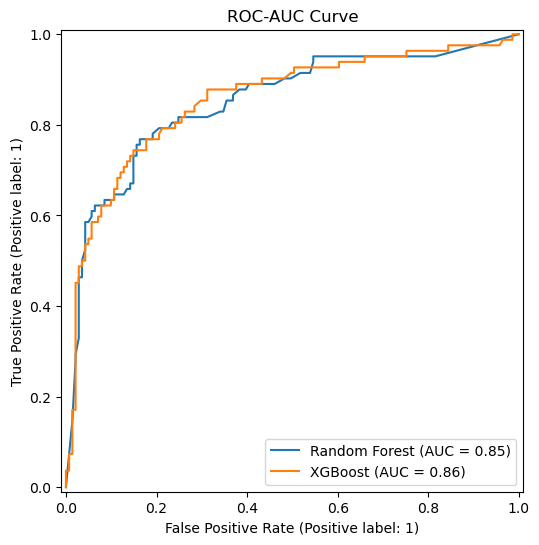

In [41]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predict with Random Forest
rf_pred = rf_model.predict(X_test_final)
rf_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]

# Evaluate Random Forest
print("Random Forest Metrics:")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"Random Forest ROC-AUC Score: {rf_roc_auc}")

# Train XGBoost Classifier with enable_categorical
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, enable_categorical=True)
xgb_model.fit(X_train_final, y_train)

# Predict with XGBoost
xgb_pred = xgb_model.predict(X_test_final)
xgb_pred_proba = xgb_model.predict_proba(X_test_final)[:, 1]

# Evaluate XGBoost
print("\nXGBoost Metrics:")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
print(f"XGBoost ROC-AUC Score: {xgb_roc_auc}")

# Plot ROC-AUC Curve
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(rf_model, X_test_final, y_test, name="Random Forest", ax=plt.gca())
RocCurveDisplay.from_estimator(xgb_model, X_test_final, y_test, name="XGBoost", ax=plt.gca())
plt.title("ROC-AUC Curve")
plt.show()

### Modelo sin ingeniería de características ni selección de variables

In [42]:
# Drop columns that won't be used in modeling
X_train_final = X_train.drop(['IsAlone','FarePerPerson','FamilySize'], axis=1)
X_test_final = X_test.drop(['IsAlone','FarePerPerson','FamilySize'], axis=1)

Random Forest Metrics:
[[116  25]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       141
           1       0.71      0.73      0.72        82

    accuracy                           0.79       223
   macro avg       0.77      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223

Random Forest ROC-AUC Score: 0.8461338868707836


/opt/miniconda3/envs/mitic-data-science-team-1-septiembre-2024-ML/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:39:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1732150532678/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
[[119  22]
 [ 22  60]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       141
           1       0.73      0.73      0.73        82

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223

XGBoost ROC-AUC Score: 0.8577235772357723


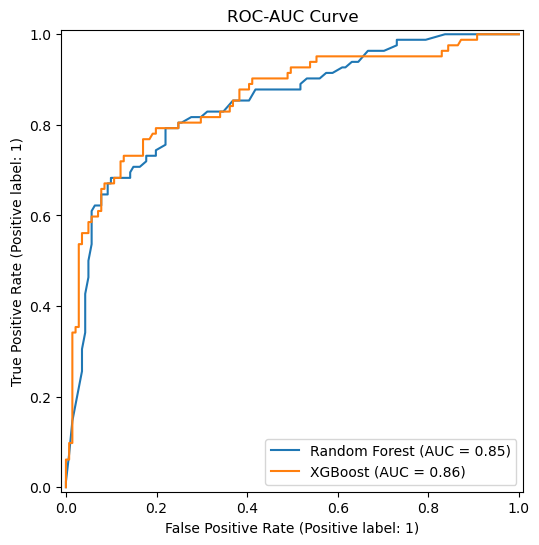

In [43]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Predict with Random Forest
rf_pred = rf_model.predict(X_test_final)
rf_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]

# Evaluate Random Forest
print("Random Forest Metrics:")
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"Random Forest ROC-AUC Score: {rf_roc_auc}")

# Train XGBoost Classifier with enable_categorical
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, enable_categorical=True)
xgb_model.fit(X_train_final, y_train)

# Predict with XGBoost
xgb_pred = xgb_model.predict(X_test_final)
xgb_pred_proba = xgb_model.predict_proba(X_test_final)[:, 1]

# Evaluate XGBoost
print("\nXGBoost Metrics:")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
print(f"XGBoost ROC-AUC Score: {xgb_roc_auc}")

# Plot ROC-AUC Curve
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(rf_model, X_test_final, y_test, name="Random Forest", ax=plt.gca())
RocCurveDisplay.from_estimator(xgb_model, X_test_final, y_test, name="XGBoost", ax=plt.gca())
plt.title("ROC-AUC Curve")
plt.show()